In [18]:
# rl-stats-eda notebook
# Import statements
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import json
import scraper as s
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError
%matplotlib inline
plt.style.use('ggplot')

# Define MongoDB database and collection
db_client = MongoClient('localhost', 27017)
db = db_client['rocket_league']
rl_replays = db['rl_replays']

In [19]:
s.ping_api()

200

### MongoDB Testing

In [20]:
"""
Currently doing in memory, but would like to send data to collection
**FOR ONE ENTRY IN NEW COLLECTION**
GAME STATS:
replay_id

PLAYER STATS (initialized with mongo):
name, car_name, goals, demo_inflicted, demo_taken
 

TEAM STATS (created from PLAYER STATS in pandas):
blue_total_goals, blue_total_demos_inflicted, blue_total_demos_taken
orange_total_goals, orange_total_demos_inflicted, orange_total_demos_taken

"""

'\nCurrently doing in memory, but would like to send data to collection\n**FOR ONE ENTRY IN NEW COLLECTION**\nGAME STATS:\nreplay_id\n\nPLAYER STATS (initialized with mongo):\nname, car_name, goals, demo_inflicted, demo_taken\n \n\nTEAM STATS (created from PLAYER STATS in pandas):\nblue_total_goals, blue_total_demos_inflicted, blue_total_demos_taken\norange_total_goals, orange_total_demos_inflicted, orange_total_demos_taken\n\n'

In [21]:
"""
Get clean data from every replay
"""

df_cols = ["blue_total_goals",
    "blue_total_demos_inflicted",
    "blue_total_demos_taken",
    "orange_total_goals",
    "orange_total_demos_inflicted",
    "orange_total_demos_taken"]

r_data = np.zeros((db.rl_replays.count(), len(df_cols)))

r_id = []


print(r_data.shape)
len(r_id)

(12199, 6)


0

In [22]:
# get relevant info from database
replay_cursor = db.rl_replays.find({}, 
    {"_id":1,
    "blue":1,
    "orange":1})


In [23]:
bad_data_row_nums = []

for row,replay in enumerate(replay_cursor):
    try:
        r_id.append(str(replay['_id']))
        # Get info for Blue Team
        for player in replay["blue"]["players"]:
            r_data[row][0] += player["stats"]["core"]["goals"]
            r_data[row][1] += player["stats"]["demo"]["inflicted"]
            r_data[row][2] += player["stats"]["demo"]["taken"]
        # Get info for Orange Team
        for player in replay["orange"]["players"]:
            r_data[row][3] += player["stats"]["core"]["goals"]
            r_data[row][4] += player["stats"]["demo"]["inflicted"]
            r_data[row][5] += player["stats"]["demo"]["taken"]
    except:
        bad_data_row_nums.append(row)    # save bad rows for dropping later

print(len(bad_data_row_nums))


8696


In [24]:
# quick entry/format check
print(f'first 5 of r_data.  Total length = {len(r_data)}')
print(r_data[:5])
print(f'\nfirst 5 of r_id.  Total length = {len(r_id)}')
print(r_id[:5])
print(f'\nfirst 5 of bad_data_row_nums.  Total length = {len(bad_data_row_nums)}')
print(bad_data_row_nums[:5])

first 5 of r_data.  Total length = 12199
[[4. 1. 4. 3. 4. 1.]
 [0. 1. 1. 5. 1. 1.]
 [7. 0. 0. 4. 0. 0.]
 [1. 1. 1. 2. 1. 1.]
 [2. 1. 6. 1. 6. 1.]]

first 5 of r_id.  Total length = 12199
['5f99c559d3221fc02865826b', '5f99c55ad3221fc02865826c', '5f99c55ad3221fc02865826d', '5f99c55bd3221fc02865826e', '5f99c55bd3221fc02865826f']

first 5 of bad_data_row_nums.  Total length = 8696
[18, 20, 22, 24, 26]


In [25]:
#df = pd.DataFrame(r_data, columns=df_cols, index=r_id)
df = pd.DataFrame(r_data, columns=df_cols)
df = df.drop(bad_data_row_nums)    # dropping rows that threw exception
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3503 entries, 0 to 12198
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blue_total_goals              3503 non-null   float64
 1   blue_total_demos_inflicted    3503 non-null   float64
 2   blue_total_demos_taken        3503 non-null   float64
 3   orange_total_goals            3503 non-null   float64
 4   orange_total_demos_inflicted  3503 non-null   float64
 5   orange_total_demos_taken      3503 non-null   float64
dtypes: float64(6)
memory usage: 191.6 KB


<AxesSubplot:>

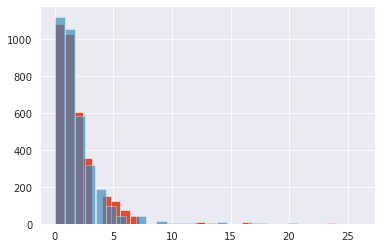

In [135]:
# TODO: Add key
df['blue_total_demos_inflicted'].hist(bins=30)
df['orange_total_demos_inflicted'].hist(bins=30, alpha=.65)

In [27]:
df.describe()

,blue_total_goals,blue_total_demos_inflicted,blue_total_demos_taken,orange_total_goals,orange_total_demos_inflicted,orange_total_demos_taken
count,3503.000000,3503.000000,3503.000000,3503.000000,3503.000000,3503.000000
mean,2.683414,1.710248,1.608336,2.693120,1.624607,1.726520
std,1.982066,2.309622,2.176968,1.912947,2.190614,2.325093
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,3.000000,1.000000,1.000000,3.000000,1.000000,1.000000
75%,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000
max,19.000000,24.000000,26.000000,15.000000,26.000000,24.000000


In [28]:
print(df['blue_total_demos_inflicted'].value_counts())
df['orange_total_demos_inflicted'].value_counts()

0.0     1078
1.0     1026
2.0      603
3.0      358
4.0      153
5.0      122
6.0       73
7.0       44
16.0      10
12.0       9
17.0       6
20.0       6
9.0        5
13.0       5
24.0       4
21.0       1
Name: blue_total_demos_inflicted, dtype: int64


0.0     1120
1.0     1056
2.0      584
3.0      320
4.0      190
5.0       97
7.0       42
6.0       41
9.0       14
14.0      11
18.0       6
20.0       5
17.0       4
11.0       3
10.0       3
13.0       2
12.0       2
26.0       1
19.0       1
8.0        1
Name: orange_total_demos_inflicted, dtype: int64

In [90]:
# Get combined goals and demos - team does not matter
all_demos_inflicted = df['blue_total_demos_inflicted'] + df['orange_total_demos_inflicted']
all_goals_scored = df['blue_total_goals'] + df['orange_total_goals']

# Add above as columns
df['all_demos_inflicted'] = all_demos_inflicted
df['all_goals_scored'] = all_goals_scored

# Mask with Quantiles
demo_top_25 = all_demos_inflicted[all_demos_inflicted >= all_demos_inflicted.quantile(q=.75)]
demo_bot_25 = all_demos_inflicted[all_demos_inflicted <= all_demos_inflicted.quantile(q=.25)]

# Get Series
goals_top_demos = df[df['all_demos_inflicted'] >= all_demos_inflicted.quantile(q=.75)]['all_goals_scored']
goals_bot_demos =df[df['all_demos_inflicted'] <= all_demos_inflicted.quantile(q=.25)]['all_goals_scored']

# Add above as columns
df['goals_top_demos'] = goals_top_demos
df['goals_bot_demos'] = goals_bot_demos


#print(f'Total Demos = {all_demos_inflicted}\n')
#print(f'Total Goals = {all_goals_scored}')
#print(f'demo_top_25 = {demo_top_25}')
#print(f'demo_bot_25 = {demo_bot_25}')
goals_top_demos

0        7.0
4        3.0
6        4.0
8        7.0
11       3.0
        ... 
12186    7.0
12187    6.0
12194    7.0
12197    7.0
12198    2.0
Name: all_goals_scored, Length: 1207, dtype: float64

In [83]:
df.head()

,blue_total_goals,blue_total_demos_inflicted,blue_total_demos_taken,orange_total_goals,orange_total_demos_inflicted,orange_total_demos_taken,all_demos_inflicted,all_goals_scored
0,4.0,1.0,4.0,3.0,4.0,1.0,5.0,7.0
1,0.0,1.0,1.0,5.0,1.0,1.0,2.0,5.0
2,7.0,0.0,0.0,4.0,0.0,0.0,0.0,11.0
3,1.0,1.0,1.0,2.0,1.0,1.0,2.0,3.0
4,2.0,1.0,6.0,1.0,6.0,1.0,7.0,3.0


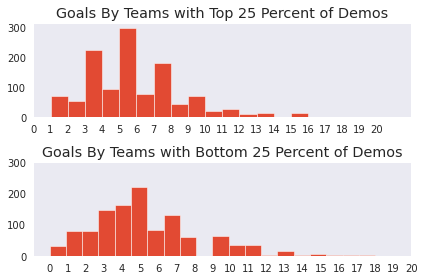

In [122]:
fig, axs = plt.subplots(2)

axs[0].hist(goals_top_demos, bins=20)
axs[0].set_title("Goals By Teams with Top 25 Percent of Demos")
axs[0].set_xticks(np.arange(0,21))
axs[0].set_yticks([0, 100, 200, 300])

axs[1].hist(goals_bot_demos, bins=20)
axs[1].set_title("Goals By Teams with Bottom 25 Percent of Demos")
axs[1].set_xticks(np.arange(0,21))
axs[1].set_yticks([0, 100, 200, 300])

fig.tight_layout()


In [30]:
all_demos_and_goals = pd.DataFrame({'all_demos_inflicted': all_demos_inflicted, 'all_goals_scored': all_goals_scored})

Text(0, 0.5, 'all_goals_scored')

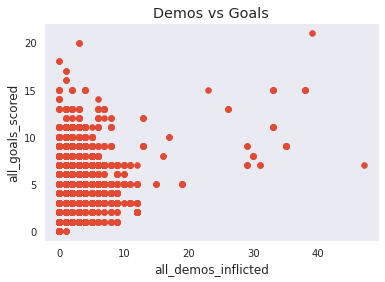

In [50]:
# Plot demos vs goals
fig, ax = plt.subplots()

ax.scatter(all_demos_inflicted, all_goals_scored)

ax.set_title("Demos vs Goals")
ax.set_xlabel('all_demos_inflicted')
ax.set_ylabel('all_goals_scored')

In [72]:
# Sample Variances
print(demo_top_25.var())     # Variance for top 25% of demos
print(demo_bot_25.var())     # Variance for bottom 25% of demos

26.793570122324336
0.24535476077937002


In [32]:
def welch_test_statistic(sample_1, sample_2):
    numerator = np.mean(sample_1) - np.mean(sample_2)
    denominator_sq = (np.var(sample_1) / len(sample_1)) + \
                        (np.var(sample_2) / len(sample_2))
    return numerator / np.sqrt(denominator_sq)

In [120]:
# Testing
# demo_bot_25, demo_top_25 -> Series    CHECK
# test_stat = welch_test_statistic(demo_bot_25, demo_top_25)
t_stats, p_value = stats.ttest_ind(goals_top_demos, goals_bot_demos, equal_var=False)
print(p_value)

0.26767432814192677


In [34]:
"""
H0: mean goals scored for top 25% of demos is greater than mean goals scored for bottom 25% of demos
HA: Mean goals scored for bottom 25% of demos is greater than mean goals scored for top 25% of demos
"""

'\nH0: mean goals scored for top 25% of demos is greater than mean goals scored for bottom 25% of demos\nHA: Mean goals scored for bottom 25% of demos is greater than mean goals scored for top 25% of demos\n'

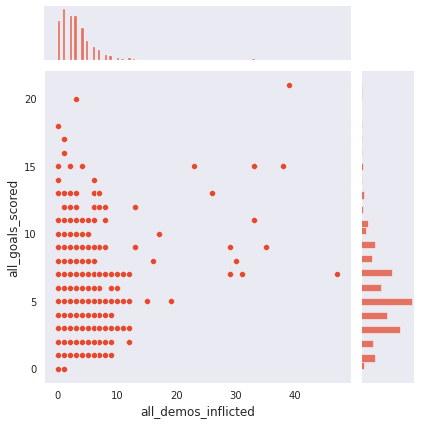

In [64]:
# Joint Plot
# ITA: hue=car_name
sns.set_style("dark")
ax = sns.jointplot(x='all_demos_inflicted', y='all_goals_scored',data=all_demos_and_goals)

Hypothesis testing steps
1) State a scientific question.
2) State the null hypothesis (H 0 )
3) State the alternative hypothesis (H a )
4) State the test statistic
5) Determine distribution under null hypothesis
6) Select a significance level
7) Collect Your Data
8) Calculate p-value
9) Decide whether to reject the null hypothesis
10) State your results